In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm

In [20]:
ebd_left_CINGULATE = pd.read_csv('/neurospin/dico/adufournet/mycode/Output/2024-07-22/11-25-46_0/ukb_random_epoch80_embeddings/full_embeddings.csv')
#print(ebd_left_CINGULATE.head())
print(ebd_left_CINGULATE.shape)

(21045, 257)


In [21]:
covar_file = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv')
print(covar_file.head())
print(covar_file.shape)

  participant_id  Sex   Age  BrainVolumeFreeSurfer_mm3  Ageattendedimaging  \
0    sub-3411469    1  65.0                  1136465.0                65.0   
1    sub-2290292    0  69.0                  1079118.0                69.0   
2    sub-3842391    0  70.0                  1124077.0                70.0   
3    sub-2758537    1  49.0                  1246758.0                49.0   
4    sub-4334619    1  70.0                  1410387.0                70.0   

  ImagingName  isBigBrain  isOld  
0     Cheadle         NaN    NaN  
1   Newcastle         NaN    NaN  
2     Cheadle         NaN    NaN  
3   Newcastle         NaN    0.0  
4     Cheadle         1.0    NaN  
(38019, 8)


In [22]:
merged_data = pd.merge(left=ebd_left_CINGULATE, right=covar_file, how='inner', left_on='ID', right_on='participant_id')

print(merged_data.shape)
print()
merged_data = merged_data.set_index('ID')
# One-hot encode the "ImagingName" column
imaging_loc = pd.get_dummies(merged_data['ImagingName'])
merged_data = pd.concat([merged_data, imaging_loc], axis=1)
merged_data = merged_data.drop(['participant_id', 'isBigBrain', 'isOld', 'ImagingName', 'Ageattendedimaging'], axis=1)

merged_data.head()

(19605, 265)



,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim252,dim253,dim254,dim255,dim256,Sex,Age,BrainVolumeFreeSurfer_mm3,Cheadle,Newcastle
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,-0.997843,12.385955,11.672585,11.285414,-22.554174,26.402634,35.521570,-9.722866,-26.329584,-1.250892,...,-12.367670,11.514998,-13.276600,9.630310,-29.099506,1,51.0,1310943.0,1,0
sub-1000458,2.552167,-24.596918,10.273945,9.501509,0.468070,15.432289,-22.359192,24.739254,-42.160220,-12.991070,...,-41.638794,1.096956,-2.909949,-14.035751,-32.715027,1,68.0,1377807.0,1,0
sub-1000575,4.118325,-9.040686,-3.261683,-11.296812,11.515161,1.691286,8.149786,-21.016586,-5.079957,6.967179,...,-43.771320,-30.863653,10.123966,-20.184015,-14.977243,1,64.0,1111215.0,1,0
sub-1000606,-3.144427,-0.618477,-12.066993,13.810851,24.415495,-14.760897,57.064540,-11.176839,-25.946890,1.500478,...,-33.549150,-9.188519,26.375956,-14.662233,24.597810,0,58.0,1229380.0,0,1
sub-1000963,-16.296228,-34.981110,19.252974,14.704968,-11.626375,29.889190,-16.691536,26.836660,-26.805521,-5.673232,...,-31.641033,12.554526,-21.678629,-4.811384,-90.145790,1,70.0,1195739.0,1,0


<AxesSubplot:>

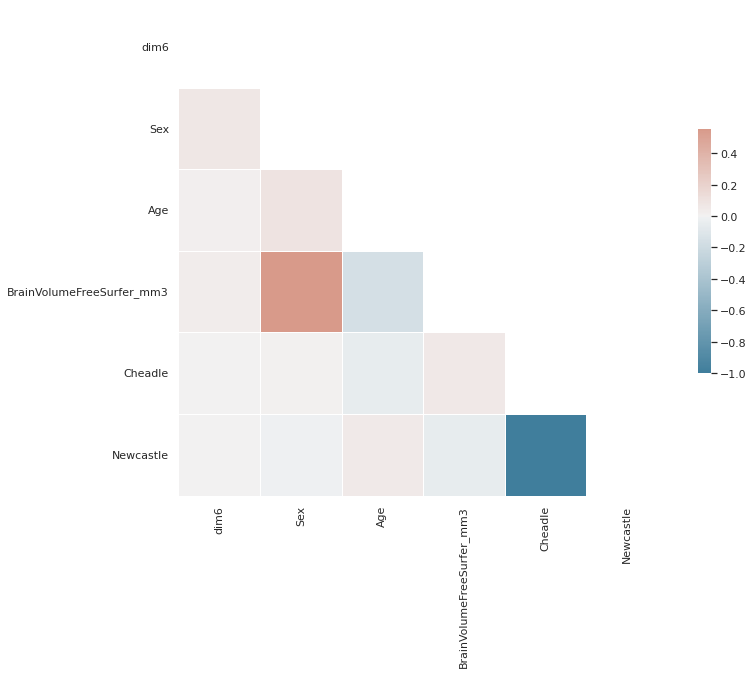

In [23]:
# Define the covariates
list_cov = ['Sex', 'Age', 'BrainVolumeFreeSurfer_mm3', 'Cheadle', 'Newcastle']#, 'isBigBrain', 'isOld']

sns.set_theme(style="white")

# Compute the correlation matrix
corr = merged_data[['dim6']+list_cov].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))


f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
            #vmin=-0.5, vmax=0.5, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [7]:
# Define the phenotype column
phenotype_col = [f'dim{i}' for i in range(1,ebd_left_CINGULATE.shape[1])]
corr = merged_data.corr()
abs(corr.loc[list_cov][phenotype_col]).max(axis=1)

Sex                          0.170334
Age                          0.088576
BrainVolumeFreeSurfer_mm3    0.189233
Cheadle                      0.028991
Newcastle                    0.028991
dtype: float64

In [24]:
for col in phenotype_col:
    # Fit the linear model
    X = merged_data[list_cov]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    y = merged_data[col]
    model = sm.OLS(y, X, missing='drop').fit()

    # Get the intercept and residuals
    intercept = model.params.loc['const']
    residuals = model.resid

    # Update the phenotype column with the pre-residualized values
    # In fact, the intercept is not usefull because of the normalization which will follow
    merged_data[col] = intercept + residuals

<AxesSubplot:>

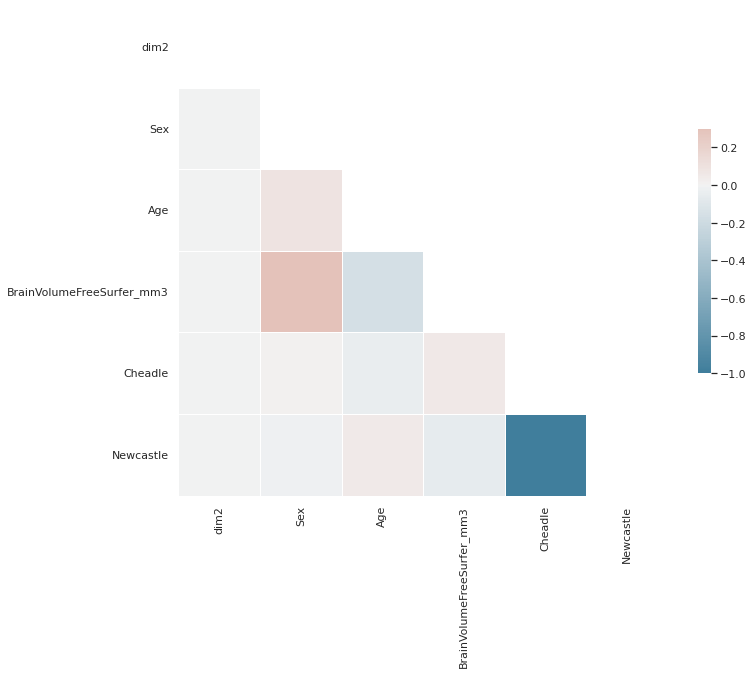

In [9]:
corr = merged_data[['dim2']+list_cov].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
corr = merged_data.corr()

In [11]:
abs(corr.loc[list_cov][phenotype_col]).max(axis=1)

Sex                          4.580384e-12
Age                          2.393808e-13
BrainVolumeFreeSurfer_mm3    3.485287e-12
Cheadle                      1.289133e-13
Newcastle                    1.288066e-13
dtype: float64

<AxesSubplot:>

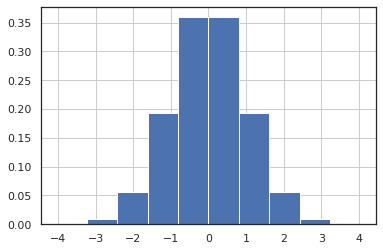

In [15]:
dim_example='dim7'
merged_data[dim_example].hist(density=True)

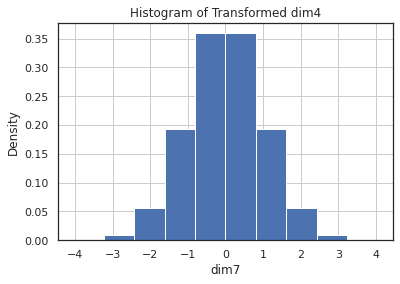

In [16]:
for dim_i in phenotype_col:
    # Calculate the ECDF values for 'dim_i'
    ecdf_values = merged_data[dim_i].rank(method='average') / len(merged_data[dim_i])

    # Apply the quantile function of the normal distribution
    qnorm_values = norm.ppf(ecdf_values - 0.5 / len(merged_data[dim_i]))

    # Assign the transformed values back to 'dim_i'
    merged_data[dim_i] = qnorm_values

# Plot the histogram of the transformed 'dim_i'
merged_data[dim_example].hist(density=True)
plt.xlabel(dim_example)
plt.ylabel('Density')
plt.title('Histogram of Transformed dim4')
plt.show()